In [1]:
from IPython.display import display
from IPython.display import Image

# A Python tutorial on validating gVirtualXRay:
## Analytic simulation vs. CT data
### Authors: F. P. Vidal

# TODO

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to images generated with the state-of-the-art Monte Caro simulation packages. We take into account i) a realistic beam spectrum and ii) the energy response of the detector.

**Material and Methods:** We simulate an image with gVirtualXRay and compare it with a ground truth image. For this purpose, we use [Gate],(http://www.opengatecollaboration.org/) a wrapper for CERN's state-of-the-art Monte Caro simulation tool: [Geant4](https://geant4.web.cern.ch/).

In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is polychromatic. The voltage is 85 kV. The filteration is 0.1 mm of copper and 1 mm of aluminium. The energy response of the detector is considered. It mimics a 600-micron thick CsI scintillator.

In [2]:
# Image(filename="../doc/pediatric-setup.png")

The sample is made of a 70x70x15mm box of water, in which 5 columns of 3 spheres of different radii (2, 3.5, and 5mm) have been inserted. A given material is associated to the spheres of each column (bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue). The columns are ordered in decreasing density. We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).

In [3]:
Image(filename="plots/digimouse_model.png", width=800)

**Results:** The [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), between the two simulated images is **MAPE 3.43%**. The **[zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is 99.99%**. 
The **[Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is 0.99**. 
As MAPE is relatively low (less than 5%), SSIM is high (close to 1), and ZNCC is high (close to 100%), we can conclude that X-ray images simulated with gVirtualXRay on GPU in milliseconds are comparable to Monte Carlo simulations that ran on supercomputers for days.

## Import packages

In [4]:
%matplotlib inline

import os # Locate files
import urllib # Download file
import zipfile # Unzip the file

import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

from scipy.stats import pearsonr # Compute the correlatio coefficient

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize # Resample the images

from tifffile import imread, imsave # Load/Write TIFF files

import datetime # For the runtime

import k3d, base64
import SimpleITK as sitk
from stl import mesh
import random
from sitk2vtk import sitk2vtk

import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up
from utils import * # Code shared across more than one notebook

SimpleGVXR 1.0.1 (2021-12-10T15:03:01) [Compiler: Apple Clang] on Darwin
gVirtualXRay core library (gvxr) 1.1.5 (2021-12-10T15:03:00) [Compiler: Apple Clang] on Darwin


## Reference CT volume

We first load the reference CT volume. It can be found at [https://neuroimage.usc.edu/neuro/Digimouse](https://neuroimage.usc.edu/neuro/Digimouse).
    
- B. Dogdas, D. Stout, A. Chatziioannou, RM Leahy, Digimouse: A 3D Whole Body Mouse Atlas from CT and Cryosection Data, Phys. Med. Bio, 52: 577-587, 2007.
- D. Stout, P. Chow, R. Silverman, R. M. Leahy, X. Lewis, S. Gambhir, A. Chatziioannou, Creating a whole body digital mouse atlas with PET, CT and cryosection images, Molecular Imaging and Biology.2002; 4(4): S27 

In [5]:
if not os.path.exists("digimouse"):
    os.mkdir("digimouse")

if not os.path.exists("digimouse/atlas.zip"):
    urllib.request.urlretrieve("http://neuroimage.usc.edu/mouse_atlas/atlas.zip", "digimouse/atlas.zip")

if not os.path.exists("digimouse/ct_data.zip"):
    urllib.request.urlretrieve("http://neuroimage.usc.edu/mouse_atlas/ct_data.zip", "digimouse/ct_data.zip")

if not os.path.exists("digimouse/atlas"):
    with zipfile.ZipFile("digimouse/atlas.zip","r") as zip_ref:
        zip_ref.extractall("digimouse/")
        
if not os.path.exists("digimouse/ct_data"):
    with zipfile.ZipFile("digimouse/ct_data.zip","r") as zip_ref:
        zip_ref.extractall("digimouse/")

In [6]:
reference_CT_volume = sitk.ReadImage("digimouse/ct_data/ct_380x992x208.hdr")
reference_CT_array = sitk.GetArrayFromImage(reference_CT_volume)

NiftiImageIO (0x7fbe55b615e0): digimouse/ct_data/ct_380x992x208.hdr is Analyze file and it's deprecated 

NiftiImageIO (0x7fbe55b615e0): digimouse/ct_data/ct_380x992x208.hdr is Analyze file and it's deprecated 



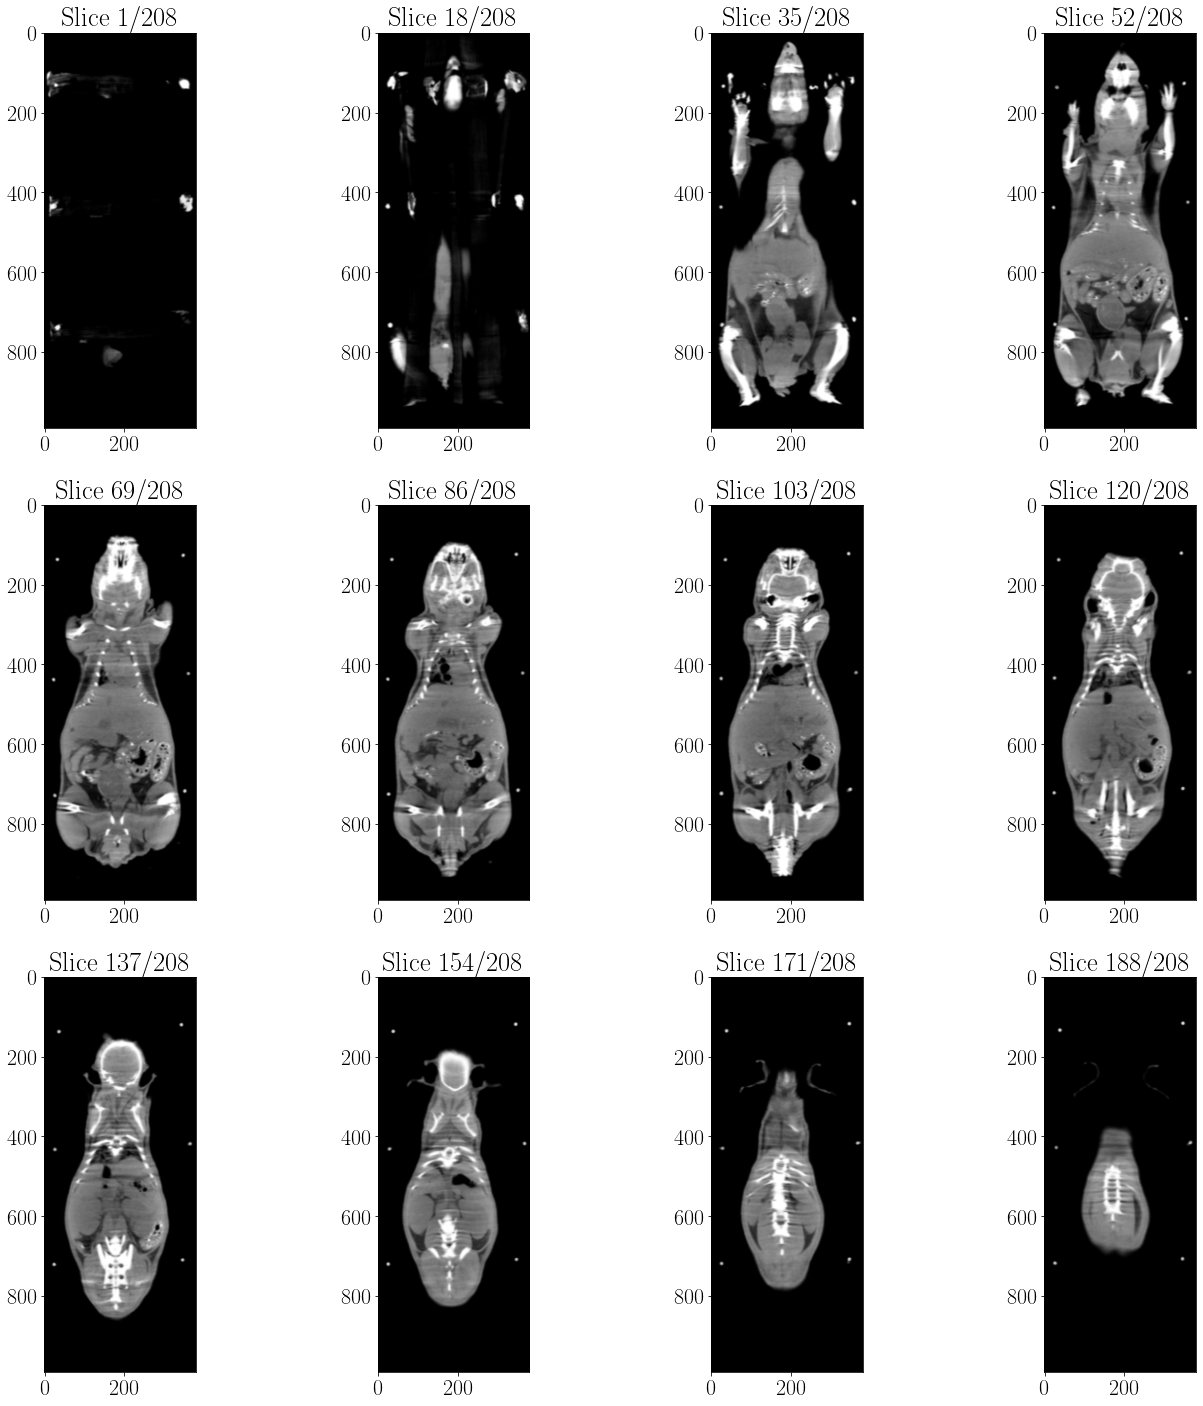

In [7]:
ncols = 4
nrows = 3

step = int(reference_CT_array.shape[0] / (ncols * nrows))
slices = range(0, int(reference_CT_array.shape[0]), step)

fig = plt.figure(figsize= (20,20))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(reference_CT_array.shape[0]))
        ax.imshow(reference_CT_array[slice_id], cmap='gray')
        
plt.tight_layout()

## Create the STL files

Load the phantom

In [8]:
phantom = sitk.ReadImage("digimouse/atlas/atlas_380x992x208.hdr")

NiftiImageIO (0x7fbe50db5350): digimouse/atlas/atlas_380x992x208.hdr is Analyze file and it's deprecated 

NiftiImageIO (0x7fbe50db5350): digimouse/atlas/atlas_380x992x208.hdr is Analyze file and it's deprecated 



Load the labels

In [9]:
df = pd.read_csv("digimouse/atlas/atlas_380x992x208.txt",
                 delimiter=" --> ",
                 names=["Label", "Organs"])

/Users/eese10/Library/Python/3.9/lib/python/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Process every structure of the phantom

In [10]:
if not os.path.exists("digimouse/segmentations"):
    os.mkdir("digimouse/segmentations")

if not os.path.exists("digimouse/meshes"):
    os.mkdir("digimouse/meshes")

meshes = []

for threshold, organ in zip(df["Label"], df["Organs"]):

    # Ignore air
    if organ != "whole brain": # and organ != "background":
        organ = organ.replace(" ", "_")
        # print("Process", organ, threshold)
        
        seg_fname = "digimouse/segmentations/" + organ + ".mha"
        mesh_fname = "digimouse/meshes/" + organ + ".stl"
        meshes.append(mesh_fname)

        # Only create the mesh if it does not exist
        if not os.path.exists(mesh_fname):
            
            print("{")
            print("    \"Label\": \"" + organ + "\",")
            print("    \"Path\": \"" + mesh_fname + "\",")
            print("    \"Unit\": \"mm\",")

            # Only segment the image it is not done as yet
            if not os.path.exists(seg_fname):
            
                # Threshold the phantom
                binary_image = (phantom == threshold)
                sitk.WriteImage(binary_image, seg_fname)

                # # Smooth the binary segmentation
                # smoothed_binary_image = sitk.AntiAliasBinary(binary_image)
                # sitk.WriteImage(smoothed_binary_image, seg_fname)
            else:
                binary_image = sitk.ReadImage(seg_fname)
                # smoothed_binary_image = sitk.ReadImage(seg_fname)
                               
            binary_array = sitk.GetArrayFromImage(binary_image)
            test = binary_array > 0.5
            
#             # binary_array = sitk.GetArrayFromImage(smoothed_binary_image)
            
            average_HU = reference_CT_array[test].mean()
            
            print("    \"Material\": [\"HU\",", average_HU, "],")
            print("    \"Type\": \"inner\",")
            print("},")
            print()

            # Create a VTK image
            vtkimg = sitk2vtk(binary_image, centre=True)
            # vtkimg = sitk2vtk(smoothed_binary_image, centre=True)

            binary_array = sitk.GetArrayFromImage(binary_image)
            min_val = binary_array.min()
            max_val = binary_array.max()
            threshold = min_val + 0.5 * (max_val - min_val)
            
            vtkmesh = extractSurface(vtkimg, threshold)
            
            writeSTL(vtkmesh, mesh_fname)
            


In [11]:
plot = k3d.plot()
plot.background_color = 0xffffff

for fname in meshes:
    
    mesh_from_stl_file = mesh.Mesh.from_file(fname)

    geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
                          range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
                          color=random.randint(0,256*256*256 - 1), 
                          wireframe=False, 
                          flat_shading=False,
                          name="fname",
                          opacity = 0.4)
    
    plot += geometry   
    
plot.display()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera_animation=[], camer…

Output()

In [12]:
plot.fetch_screenshot()

data = base64.b64decode(plot.screenshot)
with open('plots/digimouse_model.png','wb') as fp:
    fp.write(data)

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [ ]:
json2gvxr.initGVXR("notebook-digimouse.json", "OPENGL")

## X-ray source

We create an X-ray source. It is a point source.

In [ ]:
json2gvxr.initSourceGeometry()

## Spectrum

The spectrum is monochromatic.

## Detector

Create a digital detector

In [ ]:
json2gvxr.initDetector()

In [ ]:
json2gvxr.initSamples("notebook-digimouse.json", verbose=0)

## Runing the simulation

Update the 3D visualisation and take a screenshot

In [ ]:
gvxr.displayScene()

gvxr.computeXRayImage()
gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(1549.6787109375)
gvxr.setSceneRotationMatrix([-0.19267332553863525, -0.06089369207620621, 0.9793692827224731,  0.0,
                              0.9809651970863342,  -0.03645244985818863, 0.19072122871875763, 0.0,
                              0.02408679760992527,  0.9974713325500488,  0.06675821542739868, 0.0, 
                              0.0,                  0.0,                 0.0,                 1.0])

gvxr.displayScene()

In [ ]:
screenshot = gvxr.takeScreenshot()

In [ ]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off-paediatrics.pdf')
plt.savefig('plots/screenshot-beam-off-paediatrics.png')

Compute an X-ray image 50 times (to gather performance statistics)

In [ ]:
gvxr.enableArtefactFilteringOnCPU()
# gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering() # Spere inserts are missing with GPU integration when a outer surface is used for the matrix


runtimes = []

for i in range(50):
    start_time = datetime.datetime.now()
    gvxr.computeXRayImage()
    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes.append(delta_time.total_seconds() * 1000)

Save an X-ray image

In [ ]:
# Compute the L-buffers on the GPU and integrate on the GPU
x_ray_image_integration_GPU = np.array(gvxr.computeXRayImage())
x_ray_image_integration_GPU = resize(x_ray_image_integration_GPU, gate_image.shape)
imsave('gVirtualXRay_output_data/projection_raw_integration_GPU_paediatrics.tif', x_ray_image_integration_GPU.astype(np.single))

Flat-field correction

In [ ]:
total_energy_in_keV = 0.0
for energy, count in zip(energy_set, count_set):
    total_energy_in_keV += energy * count
    
total_energy_in_MeV = gvxr.getTotalEnergyWithDetectorResponse()

In [ ]:
white = np.ones(x_ray_image_integration_GPU.shape) * total_energy_in_MeV
dark = np.zeros(x_ray_image_integration_GPU.shape)

x_ray_image_integration_GPU = (x_ray_image_integration_GPU - dark) / (white - dark)

Save the corresponding image

In [ ]:
imsave('gVirtualXRay_output_data/projection_corrected_integration_GPU_paediatrics.tif', x_ray_image_integration_GPU.astype(np.single))

In [ ]:
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated using gVirtualXRay,\nintegration on GPU", y=1.02)

plt.subplot(121)
plt.imshow(x_ray_image_integration_GPU, cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(x_ray_image_integration_GPU, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/x_ray_image_integration_GPU-paediatrics.pdf')
plt.savefig('plots/x_ray_image_integration_GPU-paediatrics.png')

Compare the manual implementation with gvxr's

In [ ]:
compareImages(x_ray_image_integration_GPU, gate_image,
              "gVirtualXRay with integration on GPU vs Gate\n(checkerboard comparison)",
              'plots/comparison_integration_GPU-paediatrics')

## Comparison the analytic simulation with the Monte Carlo simulation

### Quantitative validation

Compute image metrics between the two simulated images:

1. [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD),
2. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
3. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


We use these three metrics as one is a disimilarity measurement (MAPE), two are similarity measurement (ZNCC & SSIM). MAPE and ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of MAPE s 0%; of ZNCC 100%, and SSIM 1.

In [ ]:
MAPE_integration_GPU = mape(gate_image, x_ray_image_integration_GPU)
ZNCC_integration_GPU = np.mean((gate_image - gate_image.mean()) / gate_image.std() * (x_ray_image_integration_GPU - x_ray_image_integration_GPU.mean()) / x_ray_image_integration_GPU.std())
SSIM_integration_GPU = ssim(gate_image, x_ray_image_integration_GPU, data_range=gate_image.max() - gate_image.min())

print("MAPE_integration_GPU:", "{0:0.2f}".format(100 * MAPE_integration_GPU) + "%")
print("ZNCC_integration_GPU:", "{0:0.2f}".format(100 * ZNCC_integration_GPU) + "%")
print("SSIM_integration_GPU:", "{0:0.2f}".format(SSIM_integration_GPU))

Get the total number of triangles

In [ ]:
number_of_triangles = 0

for mesh in json2gvxr.params["Samples"]:
    label = mesh["Label"]
    number_of_triangles += gvxr.getNumberOfPrimitives(label)

In [ ]:
runtime_avg = round(np.mean(runtimes))
runtime_std = round(np.std(runtimes))

Print a row of the table for the paper

In [ ]:
print("Polychromatic, detector energy response, paediatric & Gate & " + 
      "{0:0.2f}".format(100 * MAPE_integration_GPU) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_integration_GPU) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_integration_GPU) + "    &    $" +
      str(json2gvxr.params["Detector"]["NumberOfPixels"][0]) + " \\pm " + str(json2gvxr.params["Detector"]["NumberOfPixels"][1]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

In both cases, MAPE is very small (less than 1%), ZNCC is very high (more than 99%), and SSIM is very high (almost 1). We can conclude that the two images are similar. The main difference lie in the Poisson noise affecting the Monte Carlo simulation.

### Qualitative validation

Checkboard comparison

In [ ]:
font = {'size'   : 15
       }
matplotlib.rc('font', **font)

In [ ]:
fullCompareImages(gate_image,
                  x_ray_image_integration_GPU,
                  "gVirtualXRay\n with integration on GPU",
                  "plots/full_comparison_integration_GPU-paediatrics", log=True)

Plot the profiles

In [ ]:
font = {'size'   : 22
       }
matplotlib.rc('font', **font)

In [ ]:
plotTwoProfiles(json2gvxr, gate_image, x_ray_image_integration_GPU, "plots/profiles-checkerboard-paediatrics")

In [ ]:
spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]
min_limit = round(40)
max_limit = round(512 * spacing - 40)
plotTwoProfiles(json2gvxr, gate_image, x_ray_image_integration_GPU, "plots/profiles-zoom-checkerboard-paediatrics", [min_limit, max_limit])

## All done

Destroy the window

In [ ]:
gvxr.destroyAllWindows()